In [49]:
# Import model for sequence classification transformer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# import undersampler
from imblearn.under_sampling import RandomUnderSampler

# Import over sampler


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import torch
import torch
import numpy as np

import pandas as pd
import gc

In [50]:
train = pd.read_csv('../data/bronze/train.csv')

val = pd.read_csv('../data/bronze/valid.csv')

In [38]:
labels = train['label']
features = train['text']

In [39]:
# undersample train
rus = RandomUnderSampler(random_state=42)
train_features, train_labels = rus.fit_resample(features.to_frame(), labels)

In [40]:
# remove labels from train_features
train_features = train_features['text']
print(train_features)

306      ️ (@ Kenny's Strawberry Farm in Fallbrook, CA)...
26248    I love it so much ️ merry Christmas!! #familyp...
10450    It's a day late, but happy birthday ️ a little...
2955     Perfect day with my favorite person. ️ #hiking...
396      OMG so good I went twice in 1 wk! Thanks Zoe f...
                               ...                        
35664    See ya later Atascadero, I'm moooovin on! Head...
32245    Long day for everyone at Rancho Randall @ Los ...
28460    Oops, I got a little strawberry frosting and b...
42279    Recombinant fold? Something like that. Not a g...
340              Pre movie drink @ Westfield Oakridge \r\n
Name: text, Length: 18680, dtype: object


In [41]:
# Convert to pandas dataframe
train_features = pd.DataFrame(train_features, columns=['text'])
train_labels = pd.DataFrame(train_labels, columns=['label'])

In [42]:
train = pd.concat([train_features, train_labels], axis=1)

# change the order of the rows
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,text,label
0,butterfly kisses part II @ OC Fair \r\n,9
1,Little fish in a big ass pond but the bird is ...,4
2,Mornings waiting for room service and basking ...,3
3,Turn your cant's into cans #music #singer #can...,14
4,The gang all together this is trouble for a Mo...,8


In [58]:
results = pd.DataFrame(columns=['learning_rate', 'val_accuracy', 'val_loss', 'train_accuracy', 'train_loss', 'training_losses', 'validation_losses', 'model'])
model_name = "bert-base-uncased"

In [59]:
def train_epoch(model, device, train_loader, optimizer):

    model.train()
    losses = []
    correct_predictions = 0
    for batch in tqdm(train_loader, desc="Training", unit="batch"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Free up GPU memory
        del input_ids
        del attention_mask
        del labels
        del outputs
        del loss
        del logits
        del preds
        torch.cuda.empty_cache()
        gc.collect()

    
    return (correct_predictions.double() / len(train_loader.dataset)).item(), sum(losses) / len(losses)

In [60]:
def eval_model(model, device, val_loader):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return (correct_predictions.double() / len(val_loader.dataset)).item(), sum(losses) / len(losses)

In [61]:
class CustomDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        label = self.label[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [62]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
        text=df.text.to_numpy(),
        label=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [63]:
# Train the model using a list of learning rates
learning_rates = [5e-5]

MAX_LEN = 75
BATCH_SIZE = 128

# Loop through the learning rates and append the results to the results dataframe
for learning_rate in learning_rates:
    # Define the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=20, hidden_dropout_prob=0.3)

    # Define the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)

    val_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)

    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    EPOCHS = 20

    training_losses, validation_losses = [], []

    for epoch in tqdm(range(EPOCHS)):

        train_accuracy, train_loss = train_epoch(model, device, train_loader, optimizer)

        # Get the validation accuracy and loss
        val_accuracy, val_loss = eval_model(model, device, val_loader)

        # print the results
        print(f'Epoch: {epoch+1:02}')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_accuracy*100:.2f}%')

        # Use early stopping, if val accuracy does not improve for 2 epochs, stop training
        if epoch > 1 and val_loss > max(validation_losses[-2:]):
            break
    
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

    # Convert to numpy arrays
    training_losses = np.array(training_losses)
    validation_losses = np.array(validation_losses)

    print(f'Training Losses: {training_losses}')
    
    # Append the results to the results dataframe
    row = {
        'learning_rate': learning_rate,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss, 
        'train_accuracy': train_accuracy, 
        'train_loss': train_loss, 
        'training_losses': training_losses, 
        'validation_losses': validation_losses, 
        'model': model
    }

    # Concatenate the results to the results dataframe
    results.loc[len(results)] = row
        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?batch/s]

Validation:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch: 01
Train Loss: 2.497 | Train Acc: 27.08%
Val Loss: 2.276 | Val Acc: 32.76%


Training:   0%|          | 0/352 [00:00<?, ?batch/s]

Validation:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch: 02
Train Loss: 2.201 | Train Acc: 34.81%
Val Loss: 2.186 | Val Acc: 35.28%


Training:   0%|          | 0/352 [00:00<?, ?batch/s]

Validation:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch: 03
Train Loss: 2.061 | Train Acc: 38.22%
Val Loss: 2.178 | Val Acc: 35.46%


Training:   0%|          | 0/352 [00:00<?, ?batch/s]

Validation:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch: 04
Train Loss: 1.938 | Train Acc: 41.57%
Val Loss: 2.220 | Val Acc: 35.22%
Training Losses: [2.49745066 2.20107347 2.06141994]


In [64]:
# Get the best results using validation loss and save them to a csv
best_results = results.sort_values(by=['val_loss'], ascending=True)
best_results.head()

,learning_rate,val_accuracy,val_loss,train_accuracy,train_loss,training_losses,validation_losses,model
0,0.00005,0.3522,2.219774,0.415689,1.938163,"[2.4974506575275552, 2.2010734724727543, 2.061...","[2.2757848680019377, 2.1856072425842283, 2.177...",BertForSequenceClassification(\n (bert): Bert...


In [65]:
# Get losses
def plot_losses(results):
    training_losses = results.iloc[0]["training_losses"]
    valid_losses = results.iloc[0]["validation_losses"]

    print(training_losses)

    # Plot losses
    plt.plot(training_losses, label="Training loss")
    plt.plot(valid_losses, label="Validation loss")
    plt.legend()
    plt.show()

    # Save the plot
    plt.savefig("../out/unfrozen_model/best_losses.png")

[2.49745066 2.20107347 2.06141994]


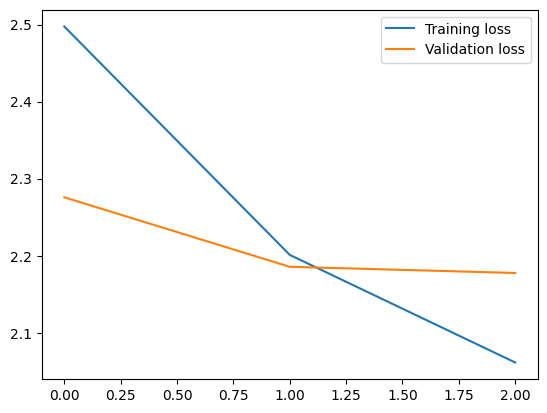

<Figure size 640x480 with 0 Axes>

In [66]:
training_losses = best_results["training_losses"]
valid_losses = best_results["validation_losses"]
plot_losses(best_results)
np.save("../out/unfrozen_model/training_losses.npy", training_losses)
np.save("../out/unfrozen_model/validation_losses.npy", valid_losses)

# Save the best model
best_model = best_results["model"].iloc[0]
best_model.save_pretrained("../out/unfrozen_model/")

# Remove models and losses from results
best_results.drop("model", axis=1, inplace=True)
best_results.drop("training_losses", axis=1, inplace=True)
best_results.drop("validation_losses", axis=1, inplace=True)

best_results.to_csv('../out/unfrozen_model/results.csv', index=False)